In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt 
import scipy
from scipy.io.wavfile import read
from scipy.signal import spectrogram
import IPython.display as ipd
import torch as torch
import re
from tqdm import tqdm
from torch.utils.data import DataLoader

from torchsummary import summary

In [2]:
import os

_REP_PATH_ = '/Users/enzoben/Desktop/études/M2 MIA/Periode 1&2/Signal/Projet_source_separation'
train_small_dir = _REP_PATH_ + '/data/train_small'
train_dir = _REP_PATH_ + '/data/train'
test_dir = _REP_PATH_ + '/data/test'

In [6]:
# For Abdellah
import os

_REP_PATH_ = os.getcwd()
train_small_dir = _REP_PATH_ + '/data/train_small'
train_dir = _REP_PATH_ + '/data/train'
test_dir = _REP_PATH_ + '/data/test'

# PROJET MVA - DLTS : Séparation de Sources

```
Enzo Benbalit
Abdellah Rebaine
```

# I. Analyse des données

## Importation des données

In [7]:
from extract_data import load_signal, interactive_spectrogramme, interactive_amplitude, plotlosses_history, SISDR_by_SNR, interactive_reconstruction

In [8]:
# Initialiser une liste pour stocker les informations
data_path = []
# Parcourir les sous-dossiers
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        # Parcourir les fichiers dans le sous-dossier
        for file in os.listdir(subdir_path):
            if file.startswith("mix_snr_") and file.endswith(".wav"):
                # Extraire le SNR du nom du fichier
                match = re.search(r"mix_snr_(-?\d+).wav", file)
                if match:
                    snr_value = match.group(1)
                    # Ajouter les informations à la liste
                    data_path.append({'Nom': subdir, 'SNR': float(snr_value), 'Path': subdir_path})

train_df_path = pd.DataFrame(data_path)
print(f"Pour l'entraînement, on dispose d'un dataset comprenant {len(train_df_path)} signaux.")

Pour l'entraînement, on dispose d'un dataset comprenant 5000 signaux.


In [9]:
data = []

# Parcourir les sous-dossiers
for subdir in os.listdir(test_dir):
    subdir_path = os.path.join(test_dir, subdir)
    if os.path.isdir(subdir_path):
        # Parcourir les fichiers dans le sous-dossier
        for file in os.listdir(subdir_path):
            if file.startswith("mix_snr_") and file.endswith(".wav"):
                # Extraire le SNR du nom du fichier
                match = re.search(r"mix_snr_(-?\d+).wav", file)
                if match:
                    snr_value = match.group(1)
                    # Ajouter les informations à la liste
                    data.append({'Nom': subdir, 'SNR': float(snr_value), 'Path': subdir_path})

test_df_path = pd.DataFrame(data)

print(f"Pour le test, on dispose d'un dataset comprenant {len(test_df_path)} signaux.")

Pour le test, on dispose d'un dataset comprenant 2000 signaux.


## Distribution des SNR

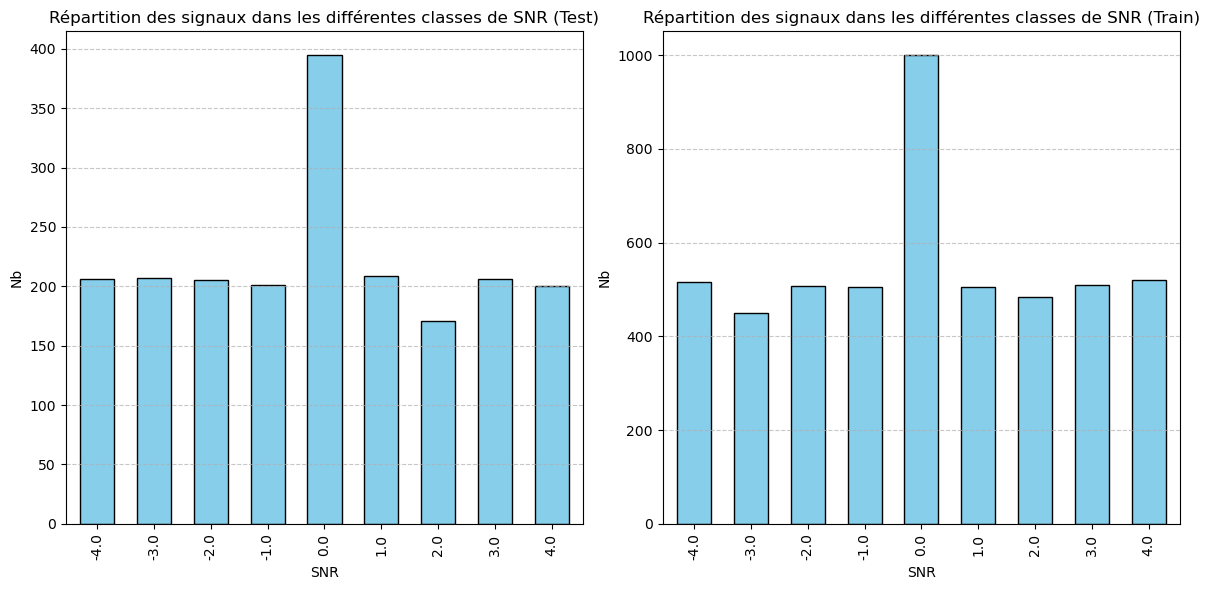

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

test_df_path.groupby("SNR").count()["Nom"].plot(
    kind='bar',
    width=0.6,
    color="skyblue",
    edgecolor="black",
    legend=False,
    ax=axes[0]  
)
axes[0].set_xlabel("SNR")
axes[0].set_ylabel("Nb")
axes[0].set_title("Répartition des signaux dans les différentes classes de SNR (Test)")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

train_df_path.groupby("SNR").count()["Nom"].plot(
    kind='bar',
    width=0.6,
    color="skyblue",
    edgecolor="black",
    legend=False,
    ax=axes[1] 
)
axes[1].set_xlabel("SNR")
axes[1].set_ylabel("Nb")
axes[1].set_title("Répartition des signaux dans les différentes classes de SNR (Train)")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


> La distribution des SNR est relativement uniforme, pour les deux sources, pour chaque valeur absolue de SNR, on a autant de signaux avec un SNR positif (plus de voix que de bruit) qu'un SNR négatif (plus de bruit que de voix).

## Analyse de quelques signaux

### **Ecoute de quelques signaux pour différents SNR**

In [11]:
sample_snr0 = load_signal(train_df_path[train_df_path['SNR'] == 0].iloc[0]['Path'])
sample_snr4 = load_signal(train_df_path[train_df_path['SNR'] == 4].iloc[0]['Path'])
sample_snrn4 = load_signal(train_df_path[train_df_path['SNR'] == -4].iloc[0]['Path'])

In [12]:
print("Le signal mixte pour un SNR de 4 dB : ")
ipd.Audio(sample_snr4.mix['audio'], rate=sample_snr4.mix['fe'])

Le signal mixte pour un SNR de 4 dB : 


In [13]:
print("Le signal mixte pour un SNR de 0 dB : ")
ipd.Audio(sample_snr0.mix['audio'], rate=sample_snr0.mix['fe'])

Le signal mixte pour un SNR de 0 dB : 


In [14]:
print("Le signal mixte pour un SNR de -4 dB : ")
ipd.Audio(sample_snrn4.mix['audio'], rate=sample_snrn4.mix['fe'])

Le signal mixte pour un SNR de -4 dB : 


### **Amplitude dans le domaine temporelle**

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0003', '0004', '0013', '0017', '0026', '0043', '0044', '0055', '0064', …

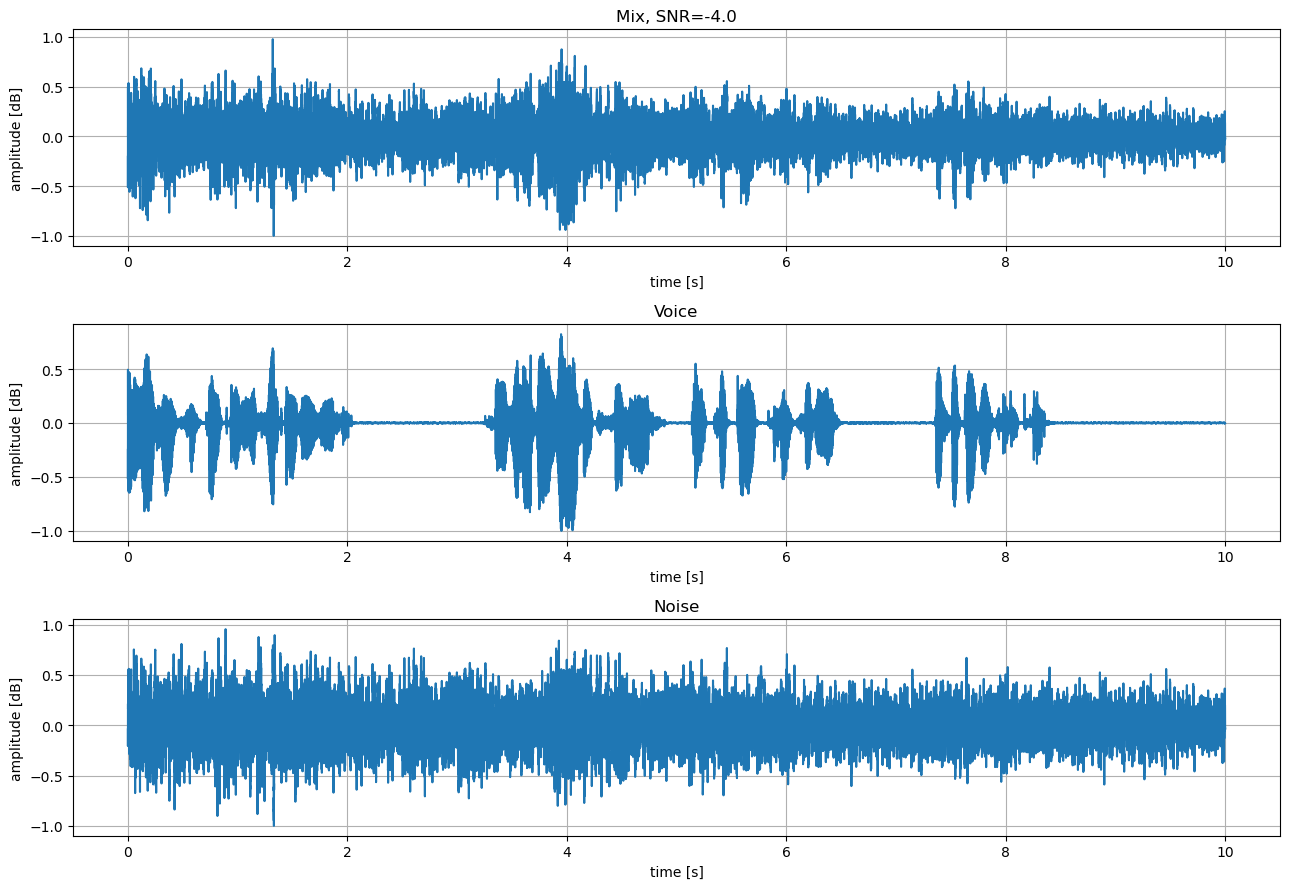

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0003', '0004', '0013', '0017', '0026', '0043', '0044', '0055', '0064', …

In [15]:
interactive_amplitude(train_df_path)

>Au niveau du signal "voix", dans le domaine temporel, on observe qu'il y a pas mal de silences, le signal est "sparse". Par ailleurs, on peut remarquer que, sur le signal "mixte", ces moments de parole correspondent souvent aux endroits de forte amplitude. A l'inverse, le signal noise ne change pas beaucoup dans le temps (ressemble beaucoup à un bruit blanc avec parfois des légères variations d'amplitude) ; ces visualisations semblent encourager des modèles qui agiraient directement sur la forme d'onde, pour extraire la voix à partir du signal mixte.

### **Spectrogramme des signaux pour différents SNR**

La taille de la fenêtre utilisée pour la STFT est un compromis entre résolution fréquentielle et résolution spectrale. Une grande fenêtre permettra une bonne résolution fréquentielle mais une mauvaise résolution temporelle. A l'inverse, une fenêtre trop petite conduit au risque de réaliser des transformées de Fourier sur des sous-signaux non stationnaires. 
Ici, nous avons décidé d'opter pour les paramètres les plus sastifaisant à vue d'oeil (sur les signaux "voice" uniquement), qui permettent d'avoir à la fois un nombre élevé de points sur la plage temporelle tout en gardant une certaine netteté et précision dans le domaine fréquenciel (visualisation des harmoniques etc...).

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0003', '0004', '0013', '0017', '0026', '0043', '0044', '0055', '0064', …

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0003', '0004', '0013', '0017', '0026', '0043', '0044', '0055', '0064', …

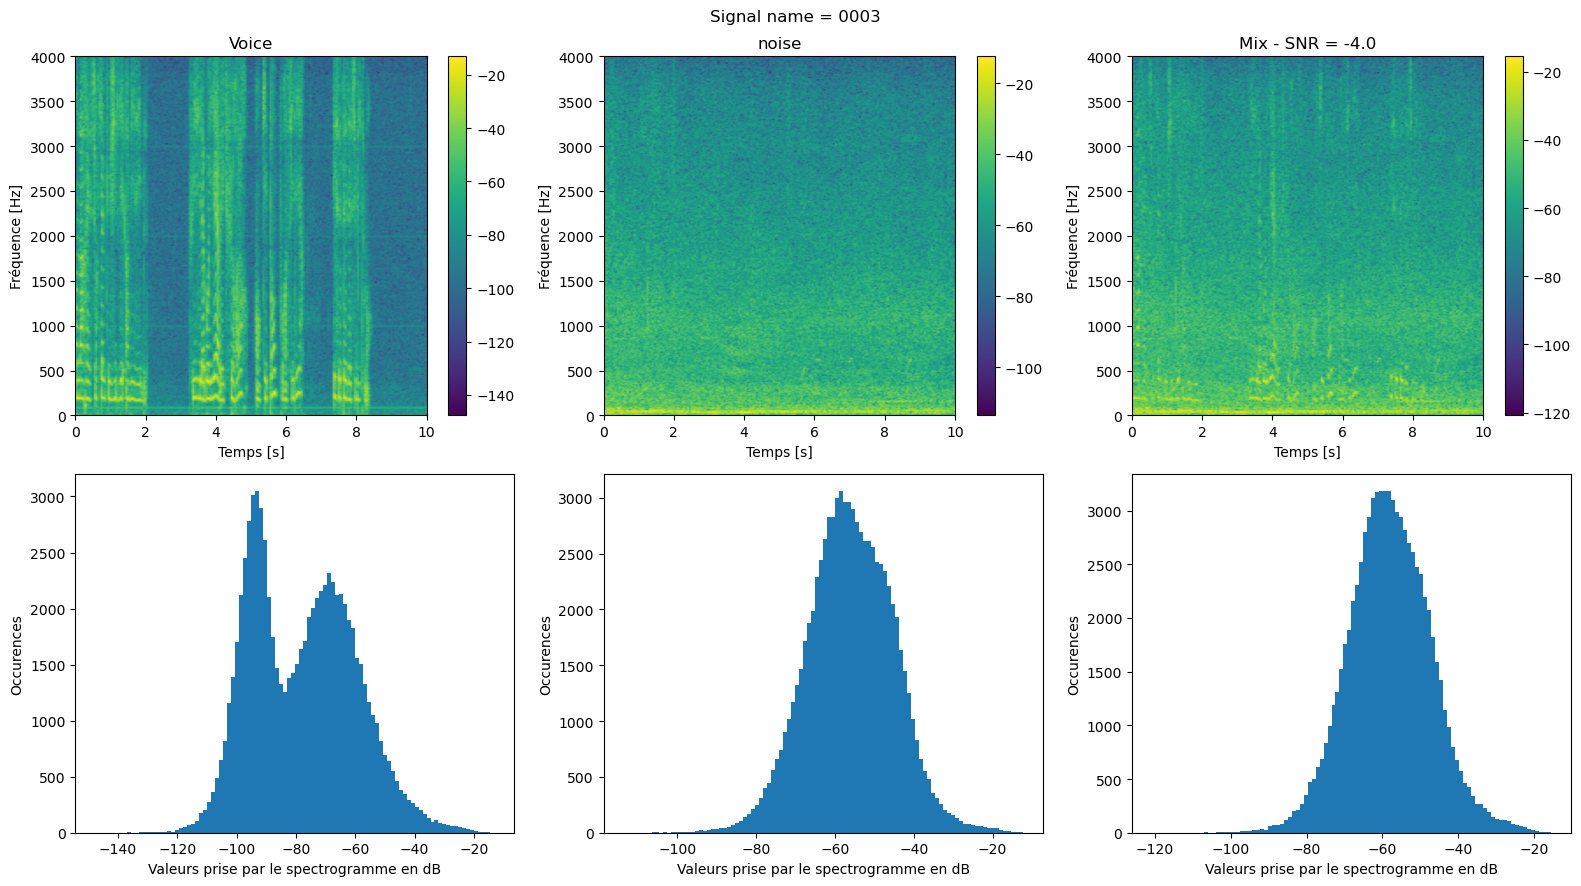

In [16]:
interactive_spectrogramme(train_df_path)

> Pour le signal "voice" on observe bien deux pics au niveau de la distrubution, qui correspondent respectivement aux moments de silence (le pic ayant le dB le plus bas) et aux moments de parole (le pic ayant le dB le plus élevé). Lorsque l'on ajoute du bruit, ces dic pics disparaissent et l'on observe une distribution Gaussienne des valeurs prises par le spectrogramme "mixte"

Pour la suite, lorsque nos modèles nécessitent une représentation temps - fréquence, nous utiliserons la fonction ```stft``` de pytorch, avec les paramètres suivants: 
- n_fft = 800
- window= torch.hann_window(800)
- return_complex = True

Ci dessous un exemple : 

In [17]:
signal_exemple = torch.tensor(sample_snr4.voice['audio'])
print(f"Le signal utilisé en exemple à les dimensions suivantes : {signal_exemple.shape}")

Le signal utilisé en exemple à les dimensions suivantes : torch.Size([80000])


In [18]:
Sxx_exemple = torch.stft(signal_exemple, n_fft=800, window=torch.hann_window(800), return_complex=True)
print(f"Le spectrogramme associé à notre signal 'exemple' à les dimensions suivantes : {Sxx_exemple.shape}")

Le spectrogramme associé à notre signal 'exemple' à les dimensions suivantes : torch.Size([401, 401])


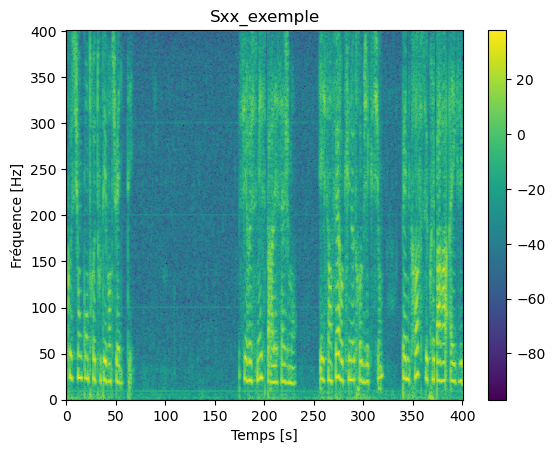

In [19]:
plt.figure()
mesh = plt.pcolormesh(20*np.log10(np.abs(np.array(Sxx_exemple))), cmap='viridis')
plt.colorbar(mesh) 
plt.title("Sxx_exemple")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence [Hz]")
plt.show()

L'objectif est maintenant d'entraîner différents modèles de deep learning pour séparer, en partant du signal mixte, les signaux voix et bruit. Pour ce faire, nous avons implémentés 4 modèles différents : 

> - Un modèle baseline, qui n'est autre qu'un encodeur (couches de convolutions 2D) décodeur (couches de déconvolutions 2D) sans interactions entre les deux parties (pas de concat)
> - Un modèle de type UNET basé sur le papier d'A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017
> - Un modèle de type Deep Clustering basé sur le papier de J.R. Hershey et Al., Deep clustering: Discriminative embeddings for segmentation and separation, ICASSP 2016
> - Un modèle de type Wave UNET basé sur le papier WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION, ISMIR 2018

Comme métrique d'évaluation (pour comparer les modèles en eux), nous utiliserons le Si-SDR.


## Les modèles de séparation de source

#### **Création d'une pipeline d'entraînement**

In [20]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [21]:
# For Abdellah
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
# Chargement des données
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data, n_fft = 800, return_spectrogram=True):
        super().__init__()
        self.path = path_to_data
        self.n_fft = n_fft
        self.length = len(os.listdir(path_to_data))

        # If True it will the getitem will return the spectrograms of the different signal. If False it will return the signals.
        self.return_spectrogram = return_spectrogram

    def __len__(self):
        return self.length

    def __getitem__(self,i):
        mixte, voice, noise = None, None, None
        Smixte, Svoice, Snoise = None, None, None
        str_i = str(i)

        # Complete the string to make it compatible with the way folders are named.
        while len(str_i) < 4:
            str_i = '0' + str_i

        # Find the path of the folder associated to the item
        path_to_sample = os.path.join(self.path, str_i)

        # Return the spectrogram if True
        if self.return_spectrogram:

            if os.path.isdir(path_to_sample):
                for filename in os.listdir(path_to_sample):
                    path_to_file = os.path.join(path_to_sample, filename)
                    if filename.endswith(".wav"):
                        _, audio = read(path_to_file)
                        audio = audio/np.max(np.abs(audio)) # Normalization
                        audio = torch.tensor(audio)

                        # Compute the different spectrograms
                        if  "mix" in filename:
                            Smixte = torch.stft(audio, n_fft=self.n_fft, window= torch.hann_window(self.n_fft), return_complex=True).unsqueeze(0)
                        elif "noise" in  filename:
                            Snoise = torch.stft(audio, n_fft=self.n_fft, window= torch.hann_window(self.n_fft), return_complex=True).unsqueeze(0)
                        else:
                            Svoice = torch.stft(audio, n_fft=self.n_fft, window= torch.hann_window(self.n_fft), return_complex=True).unsqueeze(0)
            return (Smixte, Svoice, Snoise)
        
        # Return the signals otherwise
        else:
            if os.path.isdir(path_to_sample):
                for filename in os.listdir(path_to_sample):
                    path_to_file = os.path.join(path_to_sample, filename)
                    if filename.endswith(".wav"):
                        _, audio = read(path_to_file)
                        audio = audio/np.max(np.abs(audio))
                        audio = torch.tensor(audio) # Normalization
                        if  "mix" in filename:
                            mixte = audio
                        elif "noise" in  filename:
                            noise = audio
                        else:
                            voice = audio
            return (mixte, voice, noise)

In [23]:
def train(device, model, train_data, validation_data, optimizer, criterion, mode, n_epoch, name_model, spectrogram = True):
    # Put the model on the good device
    model.to(device)

    # Save the history of the different values of the training and validation losses, to plot them.
    hist_loss_train = []
    hist_loss_valid = []
    for epoch in range(n_epoch):
        # Training phase
        model.train()
        train_loss = 0
        num_samples=0
        dloader_train = tqdm(train_data, unit='batches')
        for i, (batch_Smixte, batch_Svoice, batch_Snoise) in enumerate(dloader_train, start=1):
            optimizer.zero_grad()
            if spectrogram:
                # Take the norm of the spectrograms
                batch_Smixte, batch_Svoice, batch_Snoise = torch.abs(batch_Smixte.to(device)), torch.abs(batch_Svoice.to(device)), torch.abs(batch_Snoise.to(device))
                
                # We normalize the spectrograms
                batch_Smixte, batch_Svoice, batch_Snoise = batch_Smixte/torch.max(batch_Smixte), batch_Svoice/torch.max(batch_Svoice), batch_Snoise/torch.max(batch_Snoise)
                
                # To train the model that separate the voice from the mix
                if mode == "voice":
                    pred_Svoice = model(batch_Smixte)
                    loss = criterion(pred_Svoice,batch_Svoice)

                # To train the model that separate the noise from the mix
                elif mode == "noise":
                    pred_Snoise = model(batch_Smixte)
                    loss = criterion(pred_Snoise,batch_Snoise)
            else:
                batch_Smixte, batch_Svoice, batch_Snoise = batch_Smixte.unsqueeze(1).to(device), batch_Svoice.unsqueeze(1).to(device), batch_Snoise.unsqueeze(1).to(device)
                if mode == "voice":
                    pred_voice = model(batch_Smixte)
                    loss = criterion(pred_voice, batch_Svoice)
                elif mode == "noise":
                    pred_noise = model(batch_Smixte)
                    loss = criterion(pred_noise, batch_Snoise)
            
            # Take one gradient step
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(batch_Smixte)
            num_samples+=len(batch_Smixte)

            # Save the losses
            desc = "TRAIN : Epoch [{}/{}] - loss : {:.3f} ".format(epoch+1, n_epoch, train_loss/num_samples)
            dloader_train.set_description(desc)
        hist_loss_train.append(train_loss/num_samples)
        
        # Validation phase
        model.eval()
        valid_loss = 0
        num_samples=0
        dloader_valid = tqdm(validation_data, unit='batches')
        for i, (batch_Smixte, batch_Svoice, batch_Snoise) in enumerate(dloader_valid, start=1):
            with torch.no_grad():
                if spectrogram:
                    # Take the norm of the spectrograms
                    batch_Smixte, batch_Svoice, batch_Snoise = torch.abs(batch_Smixte.to(device)), torch.abs(batch_Svoice.to(device)), torch.abs(batch_Snoise.to(device))
                    # We normalize the spectrograms
                    batch_Smixte, batch_Svoice, batch_Snoise = batch_Smixte/torch.max(batch_Smixte), batch_Svoice/torch.max(batch_Svoice), batch_Snoise/torch.max(batch_Snoise)
                    if mode == "voice":
                        pred_Svoice = model(batch_Smixte)
                        loss = criterion(pred_Svoice,batch_Svoice)
                    elif mode == "noise":
                        pred_Snoise = model(batch_Smixte)
                        loss = criterion(pred_Snoise,batch_Snoise)
                else:
                    batch_Smixte, batch_Svoice, batch_Snoise = batch_Smixte.unsqueeze(1).to(device), batch_Svoice.unsqueeze(1).to(device), batch_Snoise.unsqueeze(1).to(device)
                    if mode == "voice":
                        pred_voice = model(batch_Smixte)
                        loss = criterion(pred_voice, batch_Svoice)
                    elif mode == "noise":
                        pred_noise = model(batch_Smixte)
                        loss = criterion(pred_noise, batch_Snoise)
                valid_loss += loss.item()*len(batch_Smixte)
                num_samples+=len(batch_Smixte)
                desc = "VALIDATION : Epoch [{}/{}] - loss : {:.3f} ".format(epoch+1, n_epoch, valid_loss/num_samples)
                dloader_valid.set_description(desc)
        hist_loss_valid.append(valid_loss/num_samples)
        torch.save(model,_REP_PATH_ + '/DLTS-PROJECT/trained_models/{}/'.format(name_model) +'{}_{}'.format(name_model, mode)+'.pth')
        pd.DataFrame({
        'train_loss' : hist_loss_train,
        'valid_loss' : hist_loss_valid}).to_csv(_REP_PATH_ +'/DLTS-PROJECT/trained_models/{}/'.format(name_model)+'{}_{}'.format(name_model, mode)+'.csv')

> Creation of the datasets and of the dataloaders for the models that use the spectrogram.

In [24]:
train_data_spec = Dataset(train_dir, n_fft= 800, return_spectrogram= True)
test_data_spec = Dataset(test_dir, n_fft= 800, return_spectrogram=True)
valid_data_spec = Dataset(train_small_dir, n_fft= 800, return_spectrogram=True)

In [25]:
# Creation of the dataloaders
batch_size = 10
dataloader_train = DataLoader(train_data_spec,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_test = DataLoader(test_data_spec,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_valid = DataLoader(valid_data_spec,
                        batch_size= batch_size,
                        shuffle=False
                       )

### **1. Baseline**

> Our baseline consists of a UNET without the concatenation steps during the decoding phase. Therefore, it's only a simple 
encoder (Conv2D with batch normalization, a padding of 2 for each layer, and LeakyReLu activation) followed by a decoder (ConvTransposed2D with batch normalization, a padding of 2 and ReLu activation). Below is a figure that encapsulate the idea.

<img src="images/baseline.png" alt="schema du modèle baseline" width="600">


Taken from Fig. 1 of the paper ```SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017``` by A. Jansson et Al. 

In [26]:
from models.BASELINE import BASELINE

baseline_voice = BASELINE(n_input_channel=1, n_output_channel=1, kernel_size=5, stride=2, padding=0)
optimizer_voice = torch.optim.Adam(baseline_voice.parameters())
loss_voice= torch.nn.L1Loss()
path_save_voice = ""

baseline_noise = BASELINE(n_input_channel=1, n_output_channel=1, kernel_size=5, stride=2, padding=0)
optimizer_noise = torch.optim.Adam(baseline_noise.parameters())
loss_noise = torch.nn.L1Loss()
path_save_noise = ""

n_epochs = 20

In [27]:
summary(baseline_voice, input_size=(1,401,401))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 199, 199]             416
       BatchNorm2d-2         [-1, 16, 199, 199]              32
         LeakyReLU-3         [-1, 16, 199, 199]               0
  EncoderConvBlock-4  [[-1, 16, 199, 199], [-1, 16, 199, 199]]               0
            Conv2d-5           [-1, 32, 98, 98]          12,832
       BatchNorm2d-6           [-1, 32, 98, 98]              64
         LeakyReLU-7           [-1, 32, 98, 98]               0
  EncoderConvBlock-8  [[-1, 32, 98, 98], [-1, 32, 98, 98]]               0
            Conv2d-9           [-1, 64, 47, 47]          51,264
      BatchNorm2d-10           [-1, 64, 47, 47]             128
        LeakyReLU-11           [-1, 64, 47, 47]               0
 EncoderConvBlock-12  [[-1, 64, 47, 47], [-1, 64, 47, 47]]               0
           Conv2d-13          [-1, 128, 22, 22]         204,928
  

In [ ]:
# train(device=device,
#       model = baseline_voice,
#       train_data=dataloader_train,
#       validation_data=dataloader_valid,
#       optimizer=optimizer_voice,
#       criterion = loss_voice,
#       mode="voice",
#       name_model="baseline",
#       n_epoch=15)

# train(device=device,
#       model = baseline_noise,
#       train_data=dataloader_train,
#       validation_data=dataloader_valid,
#       optimizer=optimizer_noise,
#       criterion = loss_noise,
#       mode="noise",
#       name_model="baseline",
#       n_epoch=15)

In [29]:
baseline_voice = torch.load(_REP_PATH_+'/final_trained_models/baseline_voice.pth', map_location="cpu")
baseline_loss_history = pd.read_csv(_REP_PATH_+'/final_trained_models/baseline_voice.csv')

C:\Users\Abdellah\AppData\Local\Temp\ipykernel_3712\1747712714.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_voice = torch.load(_REP_PATH_+'/final_trained_mod

#### **Évolution de la loss pour l'entrainement**

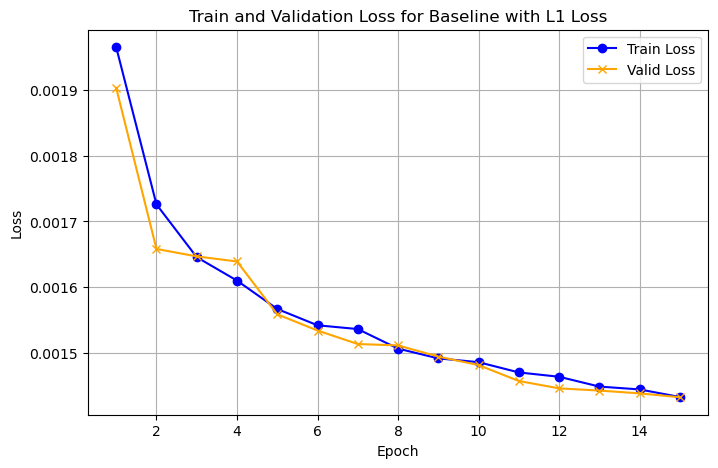

In [30]:
plotlosses_history(baseline_loss_history, model_name="Baseline with L1 Loss")

>> Sans Normalisation :

![Train and Validation Loss for UNet with L1 loss](images/hist_lossL1_baseline.png)

#### **SI-SDR en fonction des SNR**

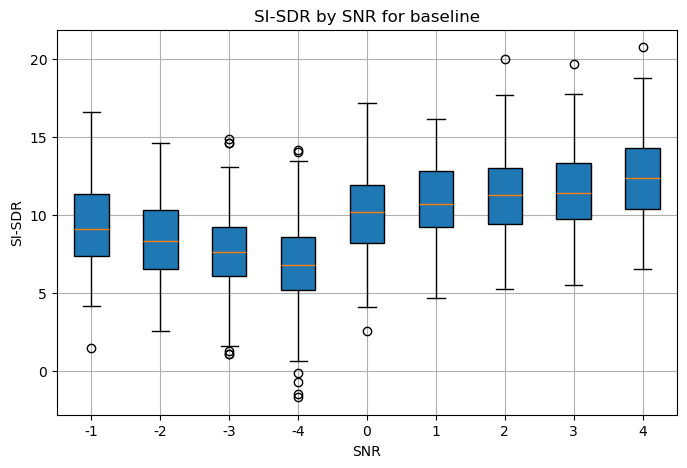

In [34]:
sisdr_by_snr = {}
sisdr_by_snr["baseline"] = SISDR_by_SNR(baseline_voice, test_df_path, model_name="baseline", device="cpu")

>> Sans Normalisation :

![SI-SDR by SNR for baseline](images/SISDR_by_SNR_baseline_lossL1.png)

#### **Observation de la forme d'onde d'un signal reconstruit**

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0000', '0004', '0010', '0011', '0018', '0032', '0038', '0060', '0078', …

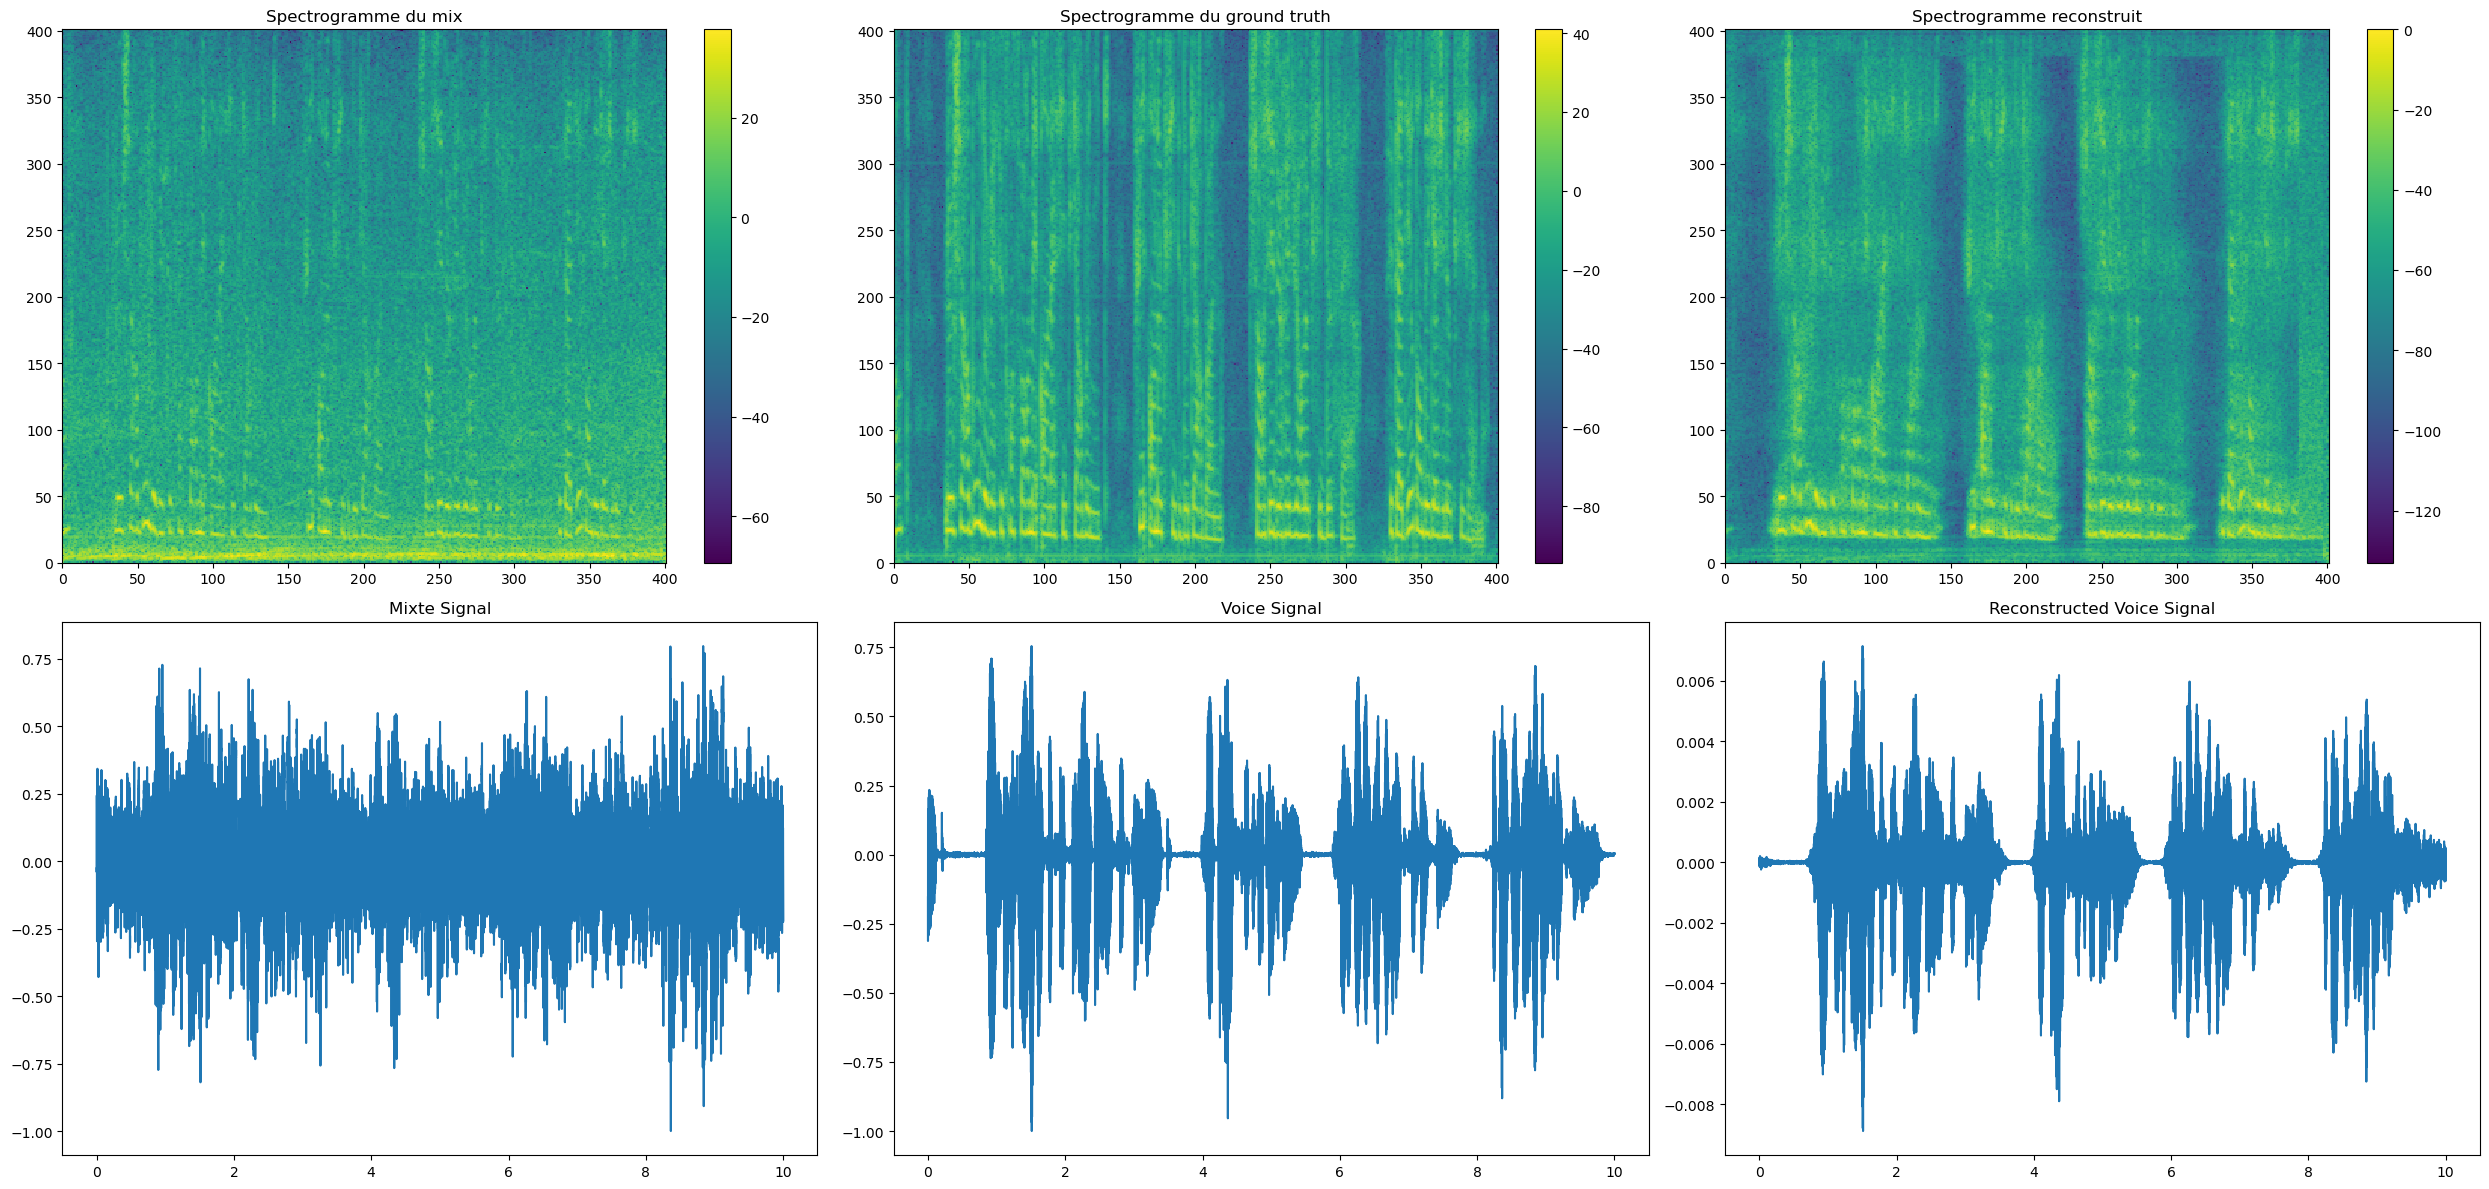

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0000', '0004', '0010', '0011', '0018', '0032', '0038', '0060', '0078', …

In [35]:
interactive_reconstruction(test_df_path, baseline_voice)

> Le signal reconstruit permet d'identifier avec précision les moments de parole et les moments de silence. Par contre, au niveau des moments de parole, on voit que, si la fréquence fondamentale ainsi que la première harmonique sont globalement bien reconstruites, les autres harmoniques sont très floues. 

**Ecoute des résultats pour le signal 0008 du dataset test, ici, le signal mixte a un SNR de -3**

In [37]:
path_to_signal = test_dir + "/0008"

signal = load_signal(path_to_signal)

Smix = torch.stft(torch.tensor(signal.mix["audio"]), n_fft = 800, window = torch.hann_window(800), return_complex = True).unsqueeze(0)
Smix_ampl = torch.abs(Smix)
Smix_ampl = Smix_ampl/torch.max(Smix_ampl)
mask = baseline_voice(Smix_ampl.unsqueeze(0))
svoice_reconst = mask*Smix/Smix_ampl
svoice_reconst = svoice_reconst / torch.max(torch.abs(svoice_reconst))

audio = torch.istft(svoice_reconst[0,0,:,:].to('cpu'), n_fft = 800, window=torch.hann_window(800))

print("audio du signal mix :")
ipd.Audio(signal.mix["audio"], rate=signal.mix["fe"])

audio du signal mix :


In [38]:
print("audio de la voix :")
ipd.Audio(signal.voice["audio"], rate=signal.voice["fe"])

audio de la voix :


In [39]:
print("audio de la voix reconstruite :")
ipd.Audio(audio.detach().numpy(), rate=8000)

audio de la voix reconstruite :


> Même si la majeure partie de bruit a pu être enlevée, notamment lors des moment de silence (lorsqu'il n'y a pas de voix), il y a toujours un bruit que l'on peut entendre lorsqu'il y a de la voix. Notre modèle a pu correctement supprimer le bruit dans les moments les plus simple (lorsqu'il n'y a que du bruit) mais il peine encore à supprimer le bruit dans lorsqu'il est melangé à la voix.

### **2. UNet**

> The UNET model used has the same overall architecture as the baseline. The main difference is that, during the deconvolution step, we add informations from the encoding part, so each layer of the deconvolution get more information about the input.

<img src="images/unet.png" alt="schema du modèle UNet" width="600">


Taken from Fig. 1 of the paper ```SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017``` by A. Jansson et Al. 

In [41]:
from models.UNET import UNet

In [42]:
unet_voice = UNet(n_input_channel=1, n_output_channel=1)
optimizer_voice = torch.optim.Adam(unet_voice.parameters())
loss_voice= torch.nn.L1Loss()
path_save_voice = ""

unet_noise = UNet(n_input_channel=1, n_output_channel=1)
optimizer_noise = torch.optim.Adam(unet_noise.parameters())
loss_noise= torch.nn.L1Loss()
path_save_noise = ""

In [43]:
summary(unet_voice, input_size= (1,401,401))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 199, 199]             416
       BatchNorm2d-2         [-1, 16, 199, 199]              32
         LeakyReLU-3         [-1, 16, 199, 199]               0
  EncoderConvBlock-4  [[-1, 16, 199, 199], [-1, 16, 199, 199]]               0
            Conv2d-5           [-1, 32, 98, 98]          12,832
       BatchNorm2d-6           [-1, 32, 98, 98]              64
         LeakyReLU-7           [-1, 32, 98, 98]               0
  EncoderConvBlock-8  [[-1, 32, 98, 98], [-1, 32, 98, 98]]               0
            Conv2d-9           [-1, 64, 47, 47]          51,264
      BatchNorm2d-10           [-1, 64, 47, 47]             128
        LeakyReLU-11           [-1, 64, 47, 47]               0
 EncoderConvBlock-12  [[-1, 64, 47, 47], [-1, 64, 47, 47]]               0
           Conv2d-13          [-1, 128, 22, 22]         204,928
  

In [44]:
# train(device=device,
#       model = unet_voice,
#       train_data=dataloader_train,
#       validation_data=dataloader_valid,
#       optimizer=optimizer_voice,
#       criterion = loss_voice,
#       mode="voice",
#       name_model="unet",
#       n_epoch=15)

# train(device=device,
#       model = unet_noise,
#       train_data=dataloader_train,
#       validation_data=dataloader_valid,
#       optimizer=optimizer_noise,
#       criterion = loss_noise,
#       mode="noise",
#       name_model="unet_norm",
#       normalize=True,
#       n_epoch=15)

In [48]:
unet_voice = torch.load(_REP_PATH_+'/final_trained_models/unet_norm_voice.pth', map_location = "cpu")
unet_loss_history = pd.read_csv(_REP_PATH_+'/final_trained_models/unet_norm_voice.csv')

C:\Users\Abdellah\AppData\Local\Temp\ipykernel_3712\2558689393.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_voice = torch.load(_REP_PATH_+'/final_trained_models/

#### **Évolution de la loss pour l'entrainement**

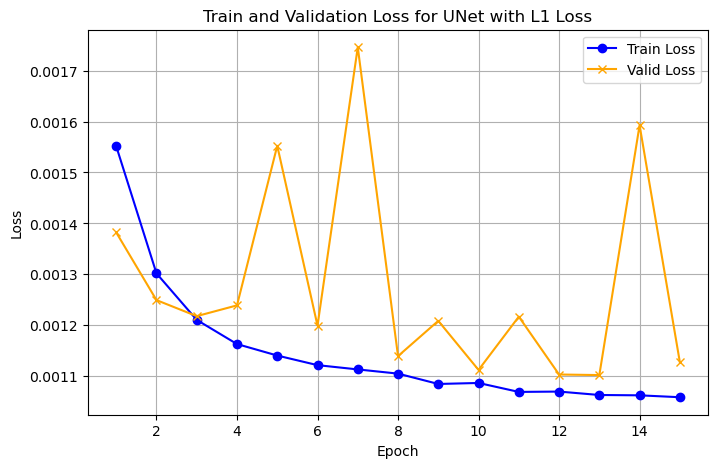

In [49]:
plotlosses_history(unet_loss_history, model_name="UNet with L1 Loss")

![Train and Validation Loss for UNet with L1 loss](images/hist_lossL1_baseline_norm.png)

#### **SI-SDR en fonction des SNR**

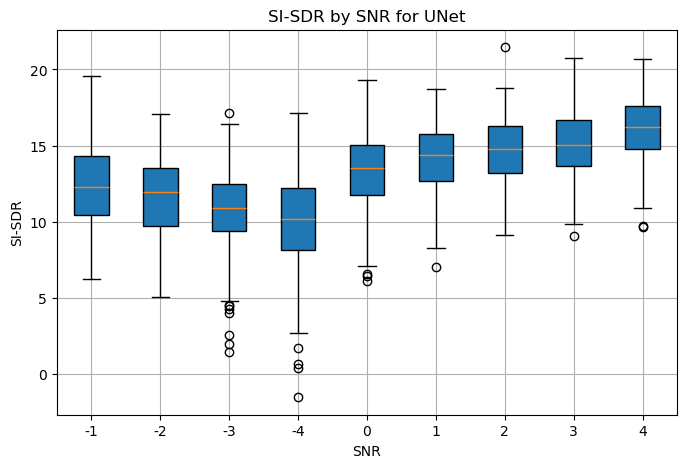

In [50]:
sisdr_by_snr["unet"] = SISDR_by_SNR(unet_voice, 
                                    test_df_path, 
                                    model_name="UNet", 
                                    device = device, 
                                    spectrogram=True
                                    )

![](images/SISDR_by_SNR_UNet_norm_lossL1.png)

#### **Observation de la forme d'onde du signal reconstruit**

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0000', '0004', '0010', '0011', '0018', '0032', '0038', '0060', '0078', …

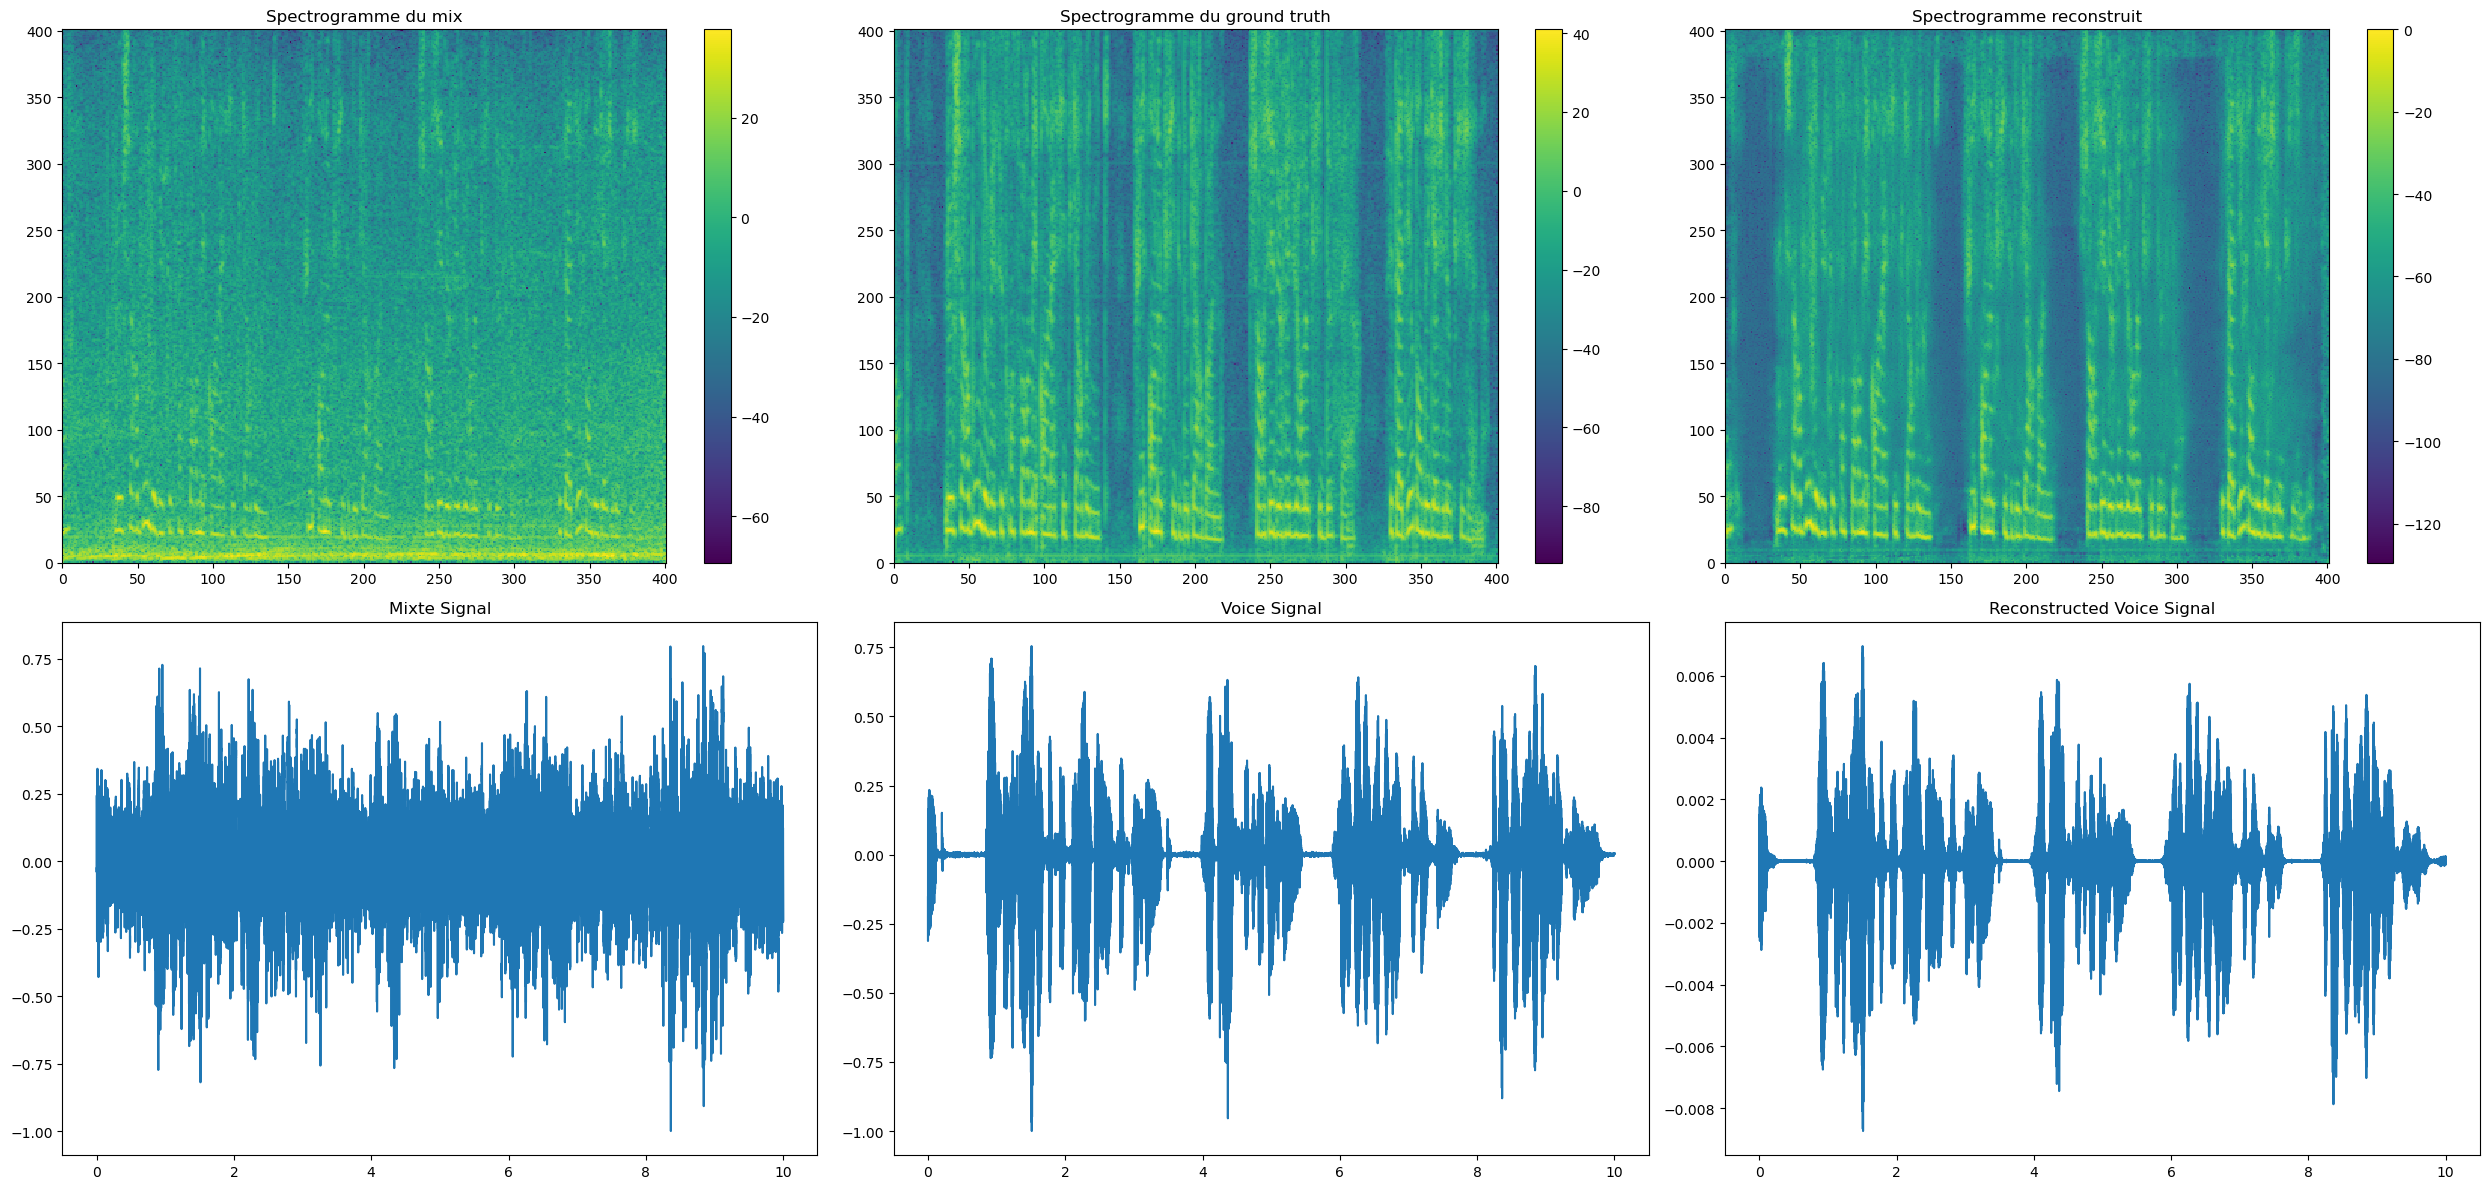

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0000', '0004', '0010', '0011', '0018', '0032', '0038', '0060', '0078', …

In [52]:
interactive_reconstruction(test_df_path, unet_voice, spectrogram=True)

>On observe ici que les harmoniques sont reconstruites avec beaucoup plus de précision que dans la baseline. L'alternance entre voix et silences est également plus précise.

**Ecoute des résultats pour le signal 0008 du dataset test, ici, le signal mixte a un SNR de 3**

In [54]:
path_to_signal = test_dir + "/0008"

signal = load_signal(path_to_signal)

Smix = torch.stft(torch.tensor(signal.mix["audio"]), n_fft = 800, window = torch.hann_window(800), return_complex = True).unsqueeze(0)
Smix_ampl = torch.abs(Smix)
Smix_ampl = Smix_ampl/torch.max(Smix_ampl)
mask = unet_voice(Smix_ampl.unsqueeze(0))
svoice_reconst = mask*Smix/Smix_ampl
svoice_reconst = svoice_reconst / torch.max(torch.abs(svoice_reconst))

audio = torch.istft(svoice_reconst[0,0,:,:].to('cpu'), n_fft = 800, window=torch.hann_window(800))

print("audio du signal mix :")
ipd.Audio(signal.mix["audio"], rate=signal.mix["fe"])

audio du signal mix :


In [55]:
print("audio de la voix :")
ipd.Audio(signal.voice["audio"], rate=signal.voice["fe"])

audio de la voix :


In [52]:
print("audio de la voie reconstruit :")
ipd.Audio(audio.detach().numpy(), rate=8000)

audio de la voie reconstruit :


### **3. Wave UNet**

<img src="images/waveunet.png" alt="schema du modèle Wave-UNet" width="900">

Ci-dessus un schéma de l'architecture utilisée.

> On travaille maintenant avec la forme d'onde directement, les dataloaders ne sont donc plus les mêmes

In [60]:
train_data_audio = Dataset(train_dir, return_spectrogram= False)
test_data_audio = Dataset(test_dir, return_spectrogram=False)
valid_data_audio = Dataset(train_small_dir, return_spectrogram=False)

In [61]:
batch_size = 10
dataloader_train_audio = DataLoader(train_data_audio,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_test_audio = DataLoader(test_data_audio,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_valid_audio = DataLoader(valid_data_audio,
                        batch_size= batch_size,
                        shuffle=True
                       )

In [62]:
from models.WAVEUNET import WaveUNet

In [63]:
waveunet_voice = WaveUNet(n_layers=14, channels_interval=24)
criterion_voice = torch.nn.MSELoss(reduction='sum')
optimizer_voice = torch.optim.Adam(waveunet_voice.parameters())

In [64]:
summary(waveunet_voice, input_size=(1, 80000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 24, 50000]             240
       BatchNorm1d-2            [-1, 24, 50000]              48
         LeakyReLU-3            [-1, 24, 50000]               0
           Dropout-4            [-1, 24, 50000]               0
 DownSamplingLayer-5            [-1, 24, 50000]               0
            Conv1d-6            [-1, 48, 25000]          10,416
       BatchNorm1d-7            [-1, 48, 25000]              96
         LeakyReLU-8            [-1, 48, 25000]               0
           Dropout-9            [-1, 48, 25000]               0
DownSamplingLayer-10            [-1, 48, 25000]               0
           Conv1d-11            [-1, 72, 12500]          31,176
      BatchNorm1d-12            [-1, 72, 12500]             144
        LeakyReLU-13            [-1, 72, 12500]               0
          Dropout-14            [-1, 72

In [65]:
# train(device=device,
#       model = waveunet_voice,
#       train_data=dataloader_train_audio,
#       validation_data=dataloader_valid_audio,
#       optimizer=optimizer_voice,
#       criterion = criterion_voice,
#       mode="voice",
#       name_model="waveunet",
#       n_epoch=15,
#       spectrogram = False)

In [67]:
waveunet_voice = torch.load(_REP_PATH_+'/final_trained_models/waveunet_voice.pth', map_location="cpu")
waveunet_loss_history = pd.read_csv(_REP_PATH_+'/final_trained_models/waveunet_voice.csv')

C:\Users\Abdellah\AppData\Local\Temp\ipykernel_3712\4277511249.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  waveunet_voice = torch.load(_REP_PATH_+'/final_trained_mod

#### **Évolution de la loss pour l'entrainement**

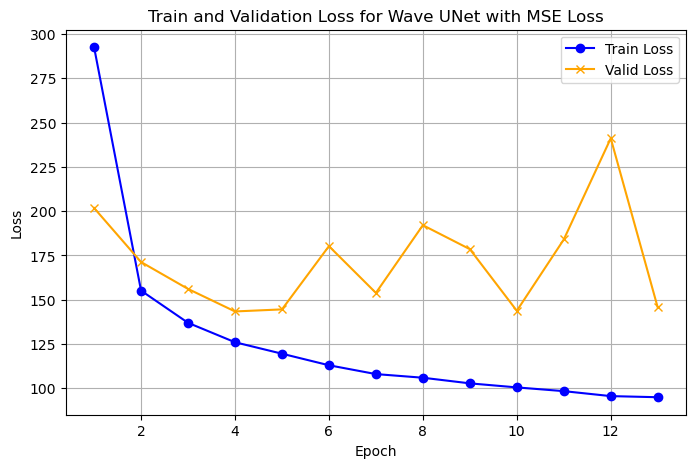

In [68]:
plotlosses_history(waveunet_loss_history, model_name="Wave UNet with MSE Loss")

![traim and validation loss Wave UNet](images/hist_loss_waveunet.png)

#### **SI-SDR en fonction des SNR**

In [105]:
sisdr_by_snr["waveunet"] = SISDR_by_SNR(waveunet_voice, test_df_path, model_name="WaveUNet", device=device, spectrogram=False)

KeyboardInterrupt: 

![SI-SDR by SNR for WaveUNet](images/SISDR_by_SNR_waveunet_lossL1.png)

#### **Observation de la forme d'onde du signal reconstruit**

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0000', '0004', '0010', '0011', '0018', '0032', '0038', '0060', '0078', …

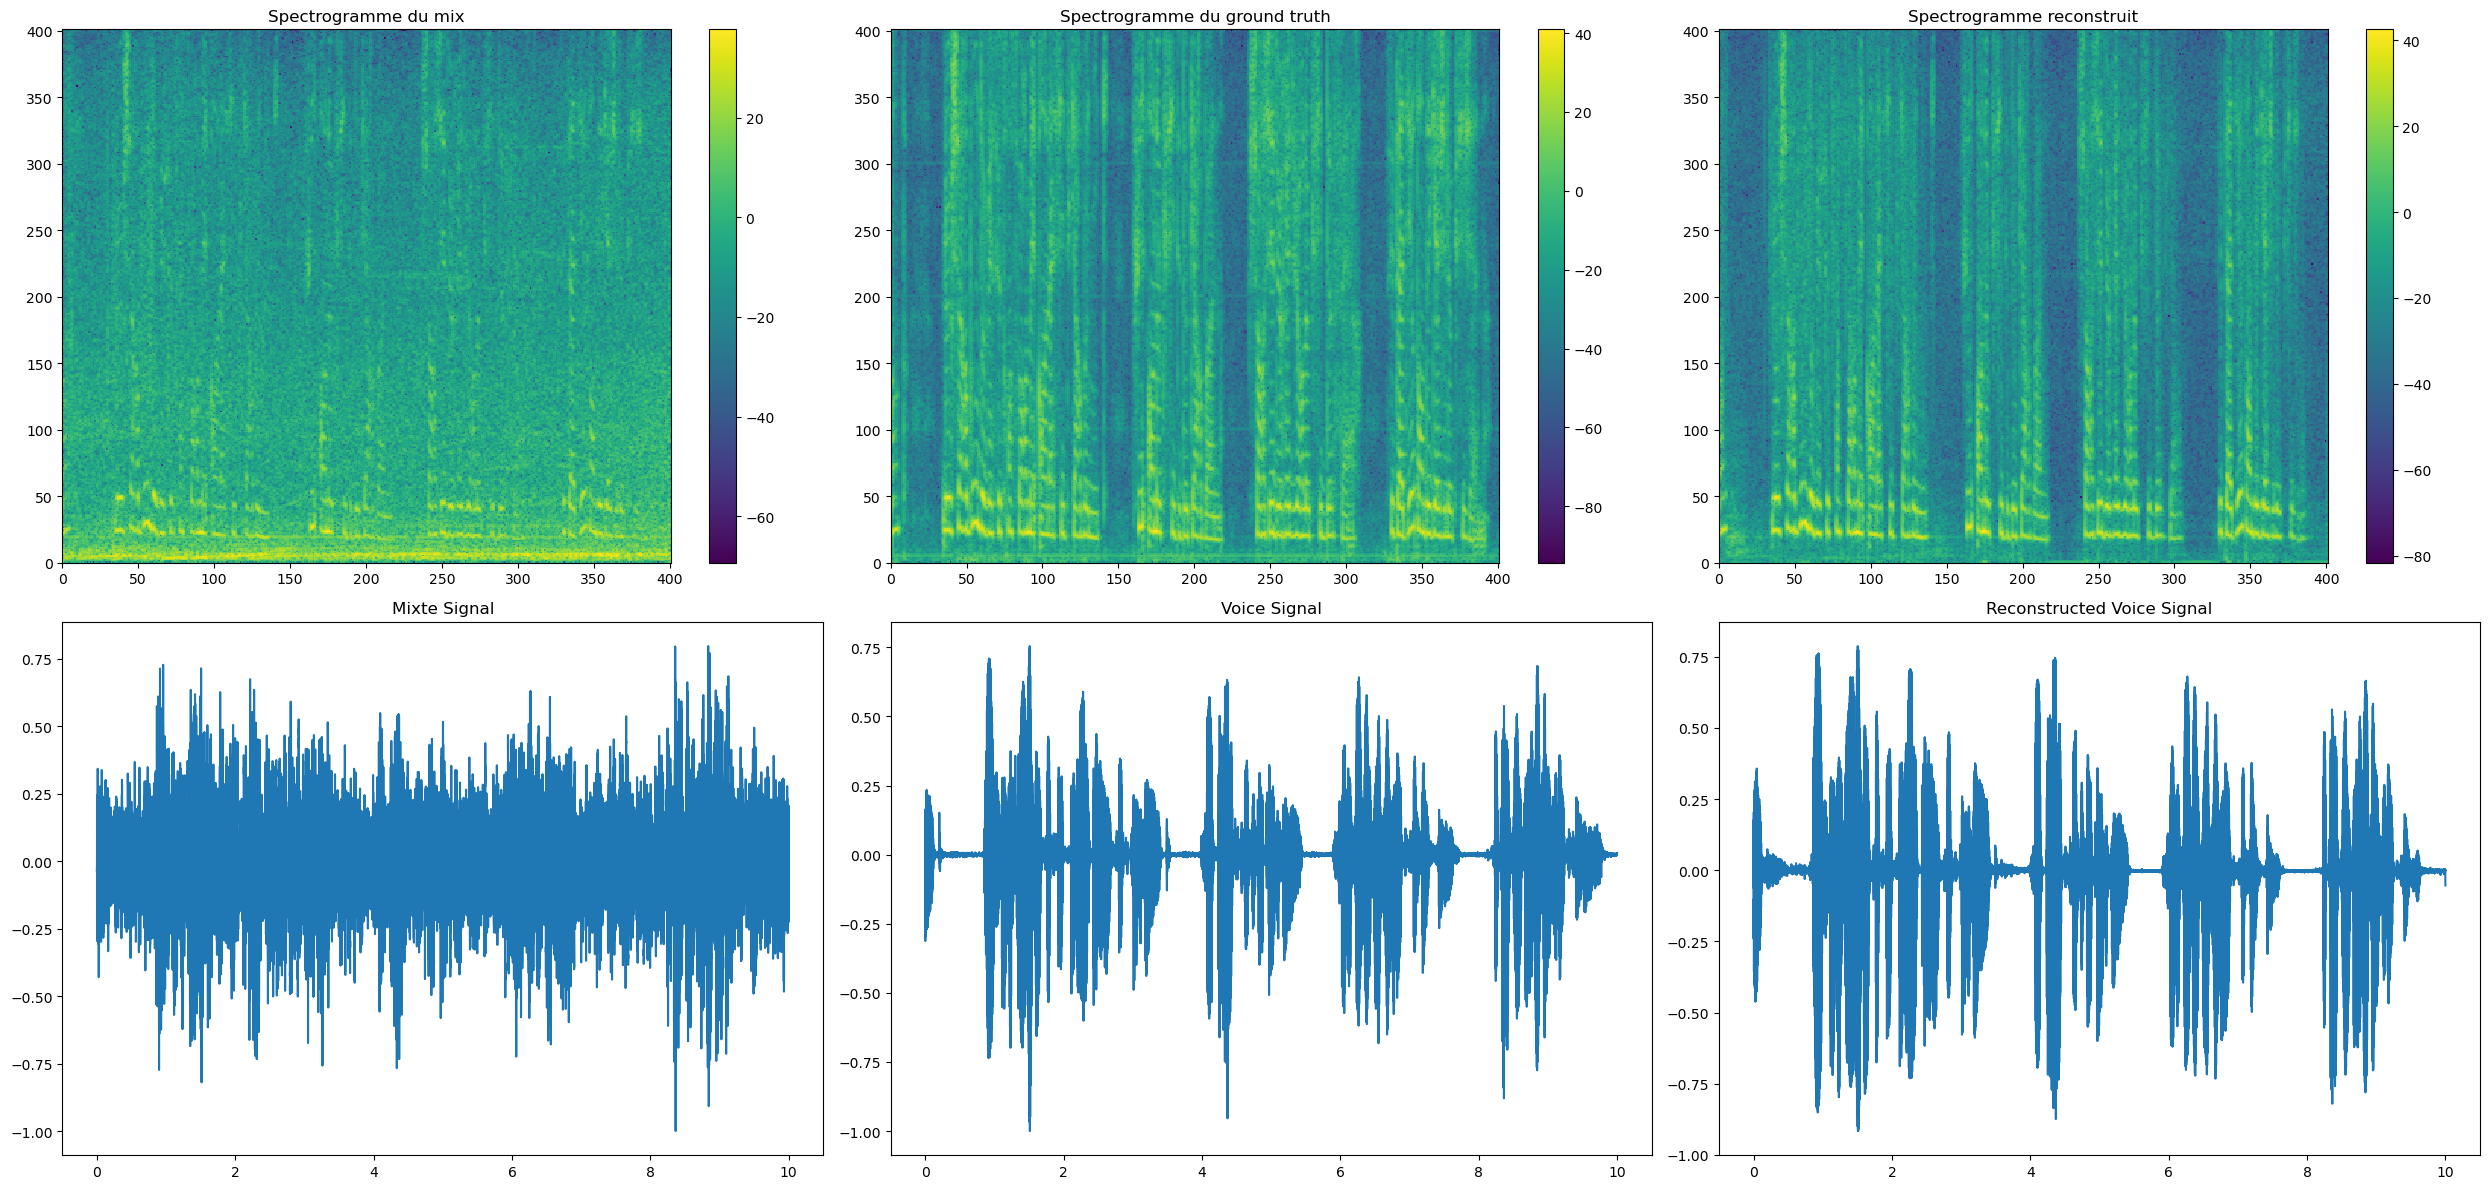

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0000', '0004', '0010', '0011', '0018', '0032', '0038', '0060', '0078', …

In [72]:
interactive_reconstruction(test_df_path, waveunet_voice, spectrogram=False)

**Ecoute des résultats pour le signal 0008 du dataset test, ici, le signal mixte a un SNR de 3**

In [74]:
path_to_signal = test_dir + "/0008"

signal = load_signal(path_to_signal)

mix_audio = torch.tensor(signal.mix["audio"]).unsqueeze(0).unsqueeze(0)
audio = waveunet_voice(mix_audio).squeeze(0).squeeze(0)

print("audio du signal mix :")
ipd.Audio(signal.mix["audio"], rate=signal.mix["fe"])

audio du signal mix :


In [76]:
print("audio de la voix :")
ipd.Audio(signal.voice["audio"], rate=signal.voice["fe"])

audio de la voix :


In [75]:
print("audio de la voix reconstruite :")
ipd.Audio(audio.detach().numpy(), rate=8000)

audio de la voix reconstruite :


### **3. Deep Clustering**

![traim and validation loss Wave UNet](images/deep-clustering-banner.png)

> Figure taken from ```MERL Researchers: John R. Hershey, Jonathan Le Roux, Shinji Watanabe, Bret Harsham (Speech & Audio).```

> In the deep clustering model, the idea is to assume that the amplitude of each "cell" in the mixte spectrogram is just the maximum between the amplitude of the same cell in the voice spectrogram and in the noise spectrogram. Therefore, the objective of the deep clustering model is to classify each pixel of the mixte spectrogram as coming from the voice or from the noise. To do so, we use an LSTM that is going to output, for each cell, an embedding. Cells that belong to the same class should have very similar embeddings, while cells that belong to different classes should have very different embeddings. 

**Chargement des données (un peu différent de ce qu'on a vu précédemment)**

In [81]:
# Pour le Deep Clustering, en entrée du LSTM, les dimensions des inputs sont [B, T,F]. Pour chaque temps t, le spectrogramme 
# donne F fréquences différentes. On considère que ces fréquences sont des canaux. Le dataset est donc un peu différent des autres, 
# on a préféré en réécrire un. Il y a peu de modifications. 
class Dataset_DC(torch.utils.data.Dataset):
    def __init__(self, path_to_data, n_fft = 800, return_spectrogram=True):
        super().__init__()
        self.path = path_to_data
        self.n_fft = n_fft
        self.length = len(os.listdir(path_to_data))

        # If True it will the getitem will return the spectrograms of the different signal. If False it will return the signals.
        self.return_spectrogram = return_spectrogram

    def __len__(self):
        return self.length

    def __getitem__(self,i):
        mixte, voice, noise = None, None, None
        Smixte, Svoice, Snoise = None, None, None
        str_i = str(i)

        # Complete the string to make it compatible with the way folders are named.
        while len(str_i) < 4:
            str_i = '0' + str_i

        # Find the path of the folder associated to the item
        path_to_sample = os.path.join(self.path, str_i)

        # Return the spectrogram if True
        if self.return_spectrogram:

            if os.path.isdir(path_to_sample):
                for filename in os.listdir(path_to_sample):
                    path_to_file = os.path.join(path_to_sample, filename)
                    if filename.endswith(".wav"):
                        _, audio = read(path_to_file)
                        audio = audio/np.max(np.abs(audio)) # Normalization
                        audio = torch.tensor(audio)

                        # Compute the different spectrograms
                        if  "mix" in filename:
                            Smixte = torch.stft(audio, n_fft=self.n_fft, window= torch.hann_window(self.n_fft), return_complex=True)
                        elif "noise" in  filename:
                            Snoise = torch.stft(audio, n_fft=self.n_fft, window= torch.hann_window(self.n_fft), return_complex=True)
                        else:
                            Svoice = torch.stft(audio, n_fft=self.n_fft, window= torch.hann_window(self.n_fft), return_complex=True)
            return (Smixte, Svoice, Snoise)
        
        # Return the signals otherwise
        else:
            if os.path.isdir(path_to_sample):
                for filename in os.listdir(path_to_sample):
                    path_to_file = os.path.join(path_to_sample, filename)
                    if filename.endswith(".wav"):
                        _, audio = read(path_to_file)
                        audio = audio/np.max(np.abs(audio))
                        audio = torch.tensor(audio) # Normalization
                        if  "mix" in filename:
                            mixte = audio
                        elif "noise" in  filename:
                            noise = audio
                        else:
                            voice = audio
            return (mixte, voice, noise)

In [84]:
train_data_dc = Dataset_DC(train_dir, return_spectrogram= True)
test_data_dc = Dataset_DC(test_dir, return_spectrogram=True)
valid_data_dc = Dataset_DC(train_small_dir, return_spectrogram=True)

In [85]:
# Creation of the dataloaders
batch_size = 10
dataloader_train = DataLoader(train_data_dc,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_test = DataLoader(test_data_dc,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_valid = DataLoader(valid_data_dc,
                        batch_size= batch_size,
                        shuffle=False
                       )

In [94]:
from models.DEEP_CLUSTERING import DEEP_CLUSTERING
from loss.dc_loss import one_hot_encoding, loss_dc

In [95]:
# We also need to adapt the training functions to the specificities of the deep clustering model (one-hot encoding ...)
def train_dc(device, model, train_data, validation_data, optimizer, criterion, n_epoch, path_save):
    model.to(device)
    hist_loss_train = []
    hist_loss_valid = []
    for epoch in range(n_epoch):
        # Training phase
        model.train()
        train_loss = 0
        num_samples=0
        dloader_train = tqdm(train_data, unit='batches')
        for i, (batch_Smixte, batch_Svoice, batch_Snoise) in enumerate(dloader_train, start=1):
            batch_Smixte, batch_Svoice, batch_Snoise = torch.abs(batch_Smixte.to(device)), torch.abs(batch_Svoice.to(device)), torch.abs(batch_Snoise.to(device))
            # We normalize the spectrograms
            batch_Smixte, batch_Svoice, batch_Snoise = batch_Smixte/torch.max(batch_Smixte), batch_Svoice/torch.max(batch_Svoice), batch_Snoise/torch.max(batch_Snoise)
            one_hot_enc = one_hot_encoding(batch_Svoice, batch_Snoise).to(device)
            optimizer.zero_grad()
            pred_embedding = model(batch_Smixte)
            loss = criterion(pred_embedding, one_hot_enc, batch_Smixte)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(batch_Smixte)
            num_samples+=len(batch_Smixte)
            desc = "TRAIN : Epoch [{}/{}] - loss : {:.3f} ".format(epoch+1, n_epoch, train_loss/num_samples)
            dloader_train.set_description(desc)
        hist_loss_train.append(train_loss/num_samples)
        # Validation phase
        model.eval()
        valid_loss = 0
        num_samples=0
        dloader_valid = tqdm(validation_data, unit='batches')
        for i, (batch_Smixte, batch_Svoice, batch_Snoise) in enumerate(dloader_valid, start=1):
            batch_Smixte, batch_Svoice, batch_Snoise = torch.abs(batch_Smixte.to(device)), torch.abs(batch_Svoice.to(device)), torch.abs(batch_Snoise.to(device))
            # We normalize the spectrograms
            batch_Smixte, batch_Svoice, batch_Snoise = batch_Smixte/torch.max(batch_Smixte), batch_Svoice/torch.max(batch_Svoice), batch_Snoise/torch.max(batch_Snoise)
            one_hot_enc = one_hot_encoding(batch_Svoice, batch_Snoise).to(device)
            with torch.no_grad():
                pred_embedding = model(batch_Smixte)
                loss = criterion(pred_embedding, one_hot_enc, batch_Smixte)
                valid_loss += loss.item()*len(batch_Smixte)
                num_samples+=len(batch_Smixte)
                desc = "VALIDATION : Epoch [{}/{}] - loss : {:.3f} ".format(epoch+1, n_epoch, valid_loss/num_samples)
                dloader_valid.set_description(desc)
        hist_loss_valid.append(valid_loss/num_samples)
        # Save the model and the history of the losses
        torch.save(model,_REP_PATH_ + '/DLTS-PROJECT/trained_models/{}/'.format(path_save) +'{}'.format(path_save)+'.pth')
        pd.DataFrame({
        'train_loss' : hist_loss_train,
        'valid_loss' : hist_loss_valid}).to_csv(_REP_PATH_ +'/DLTS-PROJECT/trained_models/{}/'.format(path_save)+'{}'.format(path_save)+'.csv')

In [96]:
dc = DEEP_CLUSTERING(401, 401, 3, 350, 20)
optimizer_dc = torch.optim.Adam(dc.parameters())
loss_voice= loss_dc
path_save = "DC"
n_epochs = 15

In [111]:
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params
    
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")
    print(f"Total parameters: {total_params}")
    return total_params

In [112]:
count_parameters(dc)

Trainable parameters: 13623020
Non-trainable parameters: 0
Total parameters: 13623020


13623020

In [98]:
# train_dc(device=device,
#       model = dc,
#       train_data=dataloader_train,
#       validation_data=dataloader_valid,
#       optimizer=optimizer_dc,
#       criterion = loss_voice,
#       path_save= path_save,
#       n_epoch=15)

In [100]:
deep_clustering = torch.load(_REP_PATH_+'/final_trained_models/deep_clustering.pth', map_location="cpu")
deep_clustering_loss_history = pd.read_csv(_REP_PATH_+'/final_trained_models/deep_clustering.csv')

C:\Users\Abdellah\AppData\Local\Temp\ipykernel_3712\1599282442.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deep_clustering = torch.load(_REP_PATH_+'/final_trained_mo

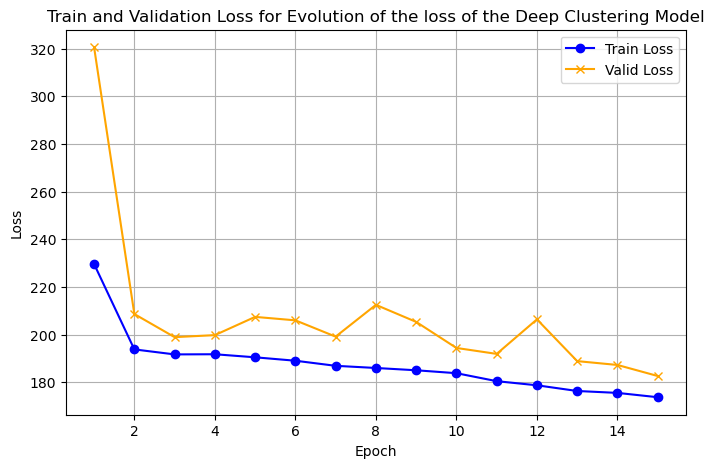

In [101]:
plotlosses_history(deep_clustering_loss_history, model_name="Evolution of the loss of the Deep Clustering Model")

![traim and validation loss Wave UNet](images/dc_loss.png)

>On the contrary to other methods, the output of the deep clustering model can't be exploited "directly". Indeed, the deep clustering model ouputs a tensor of shape [B, T, F, D], were the last dimension is the embedding dimension, T and F are the two dimensions of the time - frequency representation of the signal. Therefore, we have to do a clustering method to group the pixels of each spectrograms into two groups: one for the noise and one for the voice. Below is a function that does this job:

In [103]:
def compute_clustering(clustering_model, dc_model, signal):
    Smix = torch.stft(torch.tensor(signal), n_fft = 800, window = torch.hann_window(800), return_complex = True).unsqueeze(0).to(device)
    Smix_abs = torch.abs(Smix)
    # Compute the embeddings of the spectrograms
    Smix_emb = dc_model(Smix_abs/torch.max(Smix))
    _,T,F,D = Smix_emb.shape

    # Perform clustering
    model = clustering_model(n_clusters=2, random_state=42)
    clustering_model.fit(Smix_emb[0,:,:,:].view(-1,D).to("cpu").detach())
    class_assignments = torch.Tensor(clustering_model.predict(Smix_emb[0,:,:,:].view(-1,D).to("cpu").detach())).reshape(T,F)
    S1 = class_assignments*(Smix_abs[0,:,:].to("cpu"))
    S2 = (1-class_assignments)*(Smix_abs[0,:,:].to("cpu"))

    # Apply the two masks to the original spectrogram
    S1com = S1*(Smix[0,:,:].to("cpu")/Smix_abs[0,:,:].to("cpu"))
    S2com = S2*(Smix[0,:,:].to("cpu")/Smix_abs[0,:,:].to("cpu"))

    # Reconstruction of the audios
    au1 = torch.istft(S1com, n_fft = 800, window = torch.hann_window(800))
    au2 = torch.istft(S2com, n_fft = 800, window = torch.hann_window(800))

    return au1, au2, S1com, S2com


In [104]:
from sklearn.cluster import KMeans

In [ ]:
plot_reconstruction_dc()

In [ ]:
sisdr_by_snr["waveunet"] = SISDR_by_SNR_DC(waveunet_voice, test_df_path, model_name="WaveUNet", device=device, spectrogram=False)

## **Comparaison de l'ensemble des modèles**

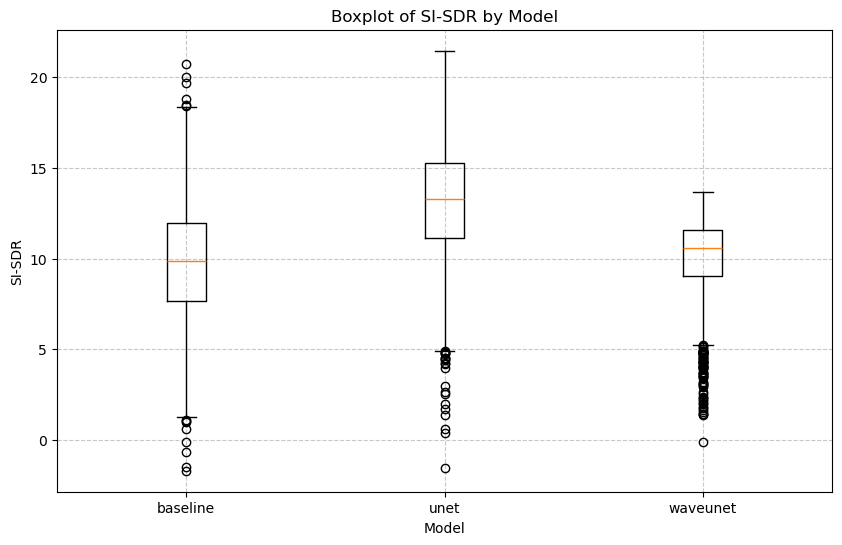

In [65]:
plt.figure(figsize=(10, 6))
positions = []
labels = []

# Boucle pour chaque modèle
for i, (model, snrs) in enumerate(sisdr_by_snr.items(), start=1):
    data = []
    for snr_values in snrs.values():
        data.extend(snr_values)  
    plt.boxplot(data, positions=[i])
    positions.append(i)
    labels.append(model)

# Configuration du graphique
plt.xticks(positions, labels)
plt.title("Boxplot of SI-SDR by Model")
plt.xlabel("Model")
plt.ylabel("SI-SDR")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()
